# 📊 Classification (XGBoost)
Dự đoán mức độ nghiêm trọng tai nạn (SEVERITY 1-4) với các đặc trưng thời gian, thời tiết và hạ tầng.

## 📚 Bước 1: Import Thư Viện
Chuẩn bị thư viện và cấu hình hiển thị.

In [1]:
# Import thư viện
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb

# Cấu hình hiển thị
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Mặc định dùng CPU; bật GPU bằng cách đặt USE_GPU = True nếu môi trường hỗ trợ
USE_GPU = False

## 📂 Bước 2: Load Dữ Liệu
Nạp dataset đã tiền xử lý (định nghĩa dtype để tiết kiệm bộ nhớ). Thông tin cột và dung lượng xem thêm trong README.

In [2]:
# Định nghĩa dtype để tối ưu memory
dtype_dict = {
    'SEVERITY': 'int8', 'YEAR': 'int16', 'QUARTER': 'int8', 'MONTH': 'int8',
    'DAY': 'int8', 'HOUR': 'int8', 'DURATION': 'int32',
    'DISTANCE': 'float32', 'LATITUDE': 'float32', 'LONGITUDE': 'float32',
    'TEMPERATURE': 'float32', 'WIND_CHILL': 'float32', 'HUMIDITY': 'float32',
    'PRESSURE': 'float32', 'VISIBILITY': 'float32', 'WIND_SPEED': 'float32',
    'PRECIPITATION': 'float32',
    'IS_WEEKEND': 'bool', 'AMENITY': 'bool', 'BUMP': 'bool', 'CROSSING': 'bool',
    'GIVE_WAY': 'bool', 'JUNCTION': 'bool', 'NO_EXIT': 'bool', 'RAILWAY': 'bool',
    'ROUNDABOUT': 'bool', 'STATION': 'bool', 'STOP': 'bool', 'TRAFFIC_CALMING': 'bool',
    'TRAFFIC_SIGNAL': 'bool', 'TURNING_LOOP': 'bool',
    'COUNTRY': 'category', 'STATE': 'category', 'COUNTY': 'str', 'CITY': 'str',
    'STREET': 'str', 'ZIPCODE': 'str', 'WIND_DIRECTION': 'category',
    'WEATHER_CONDITION': 'category', 'SUNRISE_SUNSET': 'category', 'DATE': 'str'
}

# Load dataset
df = pd.read_csv(
    '../ssis_project/preprocess/US_Accidents_March23-preprocessed.csv',
    dtype=dtype_dict,
    parse_dates=['DATE']
 )

print(f"📊 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

📊 Shape: 5,539,531 rows × 41 columns
💾 Memory usage: 1.90 GB
💾 Memory usage: 1.90 GB


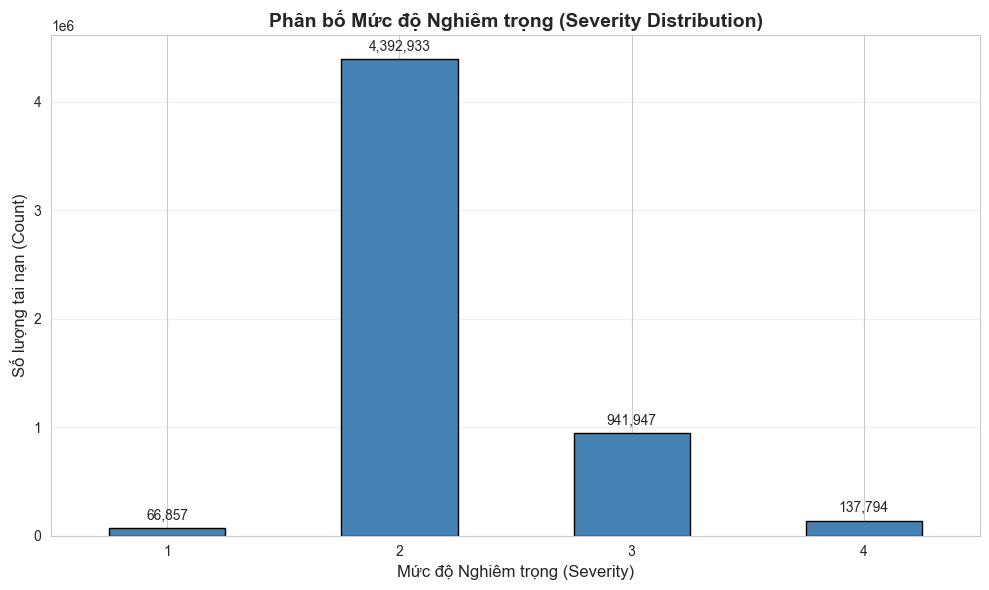

In [3]:
# Kiểm tra phân bố SEVERITY (target variable)
severity_counts = df['SEVERITY'].value_counts().sort_index()

Path('figures/classification').mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(10, 6))
severity_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Phân bố Mức độ Nghiêm trọng (Severity Distribution)', fontsize=14, weight='bold')
plt.xlabel('Mức độ Nghiêm trọng (Severity)', fontsize=12)
plt.ylabel('Số lượng tai nạn (Count)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(severity_counts.values):
    plt.text(i, v + 50000, f'{v:,}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('figures/classification/00_severity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 🔧 Bước 3: Feature Engineering (Chuẩn Bị Đặc Trưng)

Chuẩn bị features để đưa vào mô hình XGBoost:

1. **Xử lý Missing Values**: Fill giá trị thiếu (weather columns có ~1-20% missing)
2. **Encode Categorical**: Chuyển STATE, COUNTY, CITY... thành số
3. **Feature Selection**: Chọn các features hữu ích, bỏ những features không cần thiết
4. **Train-Test Split**: Chia 80% train, 20% test (stratified theo SEVERITY)

In [4]:
# Bước 3.1: Xử lý Missing Values
missing_cols = df.columns[df.isnull().any()]
missing_total = df[missing_cols].isnull().sum().sum()
print(f"Missing values: {missing_total:,} across {len(missing_cols)} columns")

for col in missing_cols:
    if df[col].dtype in ['float32', 'int32', 'int16', 'int8']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

remaining = df[missing_cols].isnull().sum().sum()
print(f"Remaining missing values: {remaining}")

Missing values: 2,942,182 across 7 columns
Remaining missing values: 0
Remaining missing values: 0


In [ ]:
# Bước 3.2: Feature Selection
drop_cols = ['DATE', 'COUNTRY', 'STREET', 'ZIPCODE', 'CITY', 'COUNTY']

X = df.drop(columns=drop_cols + ['SEVERITY'])
y = df['SEVERITY'].values - 1  # 1-4 → 0-3
print(f"Feature matrix: {X.shape}")
print(f"Target vector: {y.shape}")

Feature matrix: (5539531, 34)
Target vector: (5539531,)


In [6]:
# Bước 3.3: Encode Categorical Variables
label_encoders = {}
categorical_cols = X.select_dtypes(include=['category', 'object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype('int8')

print(f"Encoded {len(categorical_cols)} categorical columns; converted {len(bool_cols)} boolean columns to int8.")

Encoded 4 categorical columns; converted 14 boolean columns to int8.


In [7]:
# Bước 3.4: Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
 )
print(f"Train: {X_train.shape[0]:,} samples; Test: {X_test.shape[0]:,} samples")

Train: 4,431,624 samples; Test: 1,107,907 samples


## 🤖 Bước 4: Training XGBoost Model

**XGBoost Parameters**:
- `objective='multi:softprob'`: Multi-class classification với probability output
- `num_class=4`: 4 classes (Severity 0-3, tương ứng 1-4 ban đầu)
- `max_depth=6`: Độ sâu cây quyết định (cao hơn = phức tạp hơn, dễ overfit)
- `learning_rate=0.1`: Tốc độ học (thấp hơn = học chậm nhưng chính xác hơn)
- `n_estimators=100`: Số lượng cây (nhiều hơn = tốt hơn nhưng chậm hơn)
- `tree_method='gpu_hist'` hoặc `'hist'`: Sử dụng GPU nếu có, không thì CPU

In [8]:
import time

params = {
    'objective': 'multi:softprob',
    'num_class': 4,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss',
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'gpu_hist' if USE_GPU else 'hist'
}
if USE_GPU:
    params['gpu_id'] = 0

model = xgb.XGBClassifier(**params, n_estimators=100)
start_time = time.time()
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10
 )
training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes using {'GPU' if USE_GPU else 'CPU'}.")

[0]	validation_0-mlogloss:0.96758	validation_1-mlogloss:0.96760
[10]	validation_0-mlogloss:0.62267	validation_1-mlogloss:0.62291
[10]	validation_0-mlogloss:0.62267	validation_1-mlogloss:0.62291
[20]	validation_0-mlogloss:0.49615	validation_1-mlogloss:0.49647
[20]	validation_0-mlogloss:0.49615	validation_1-mlogloss:0.49647
[30]	validation_0-mlogloss:0.44320	validation_1-mlogloss:0.44354
[30]	validation_0-mlogloss:0.44320	validation_1-mlogloss:0.44354
[40]	validation_0-mlogloss:0.41541	validation_1-mlogloss:0.41577
[40]	validation_0-mlogloss:0.41541	validation_1-mlogloss:0.41577
[50]	validation_0-mlogloss:0.40072	validation_1-mlogloss:0.40117
[50]	validation_0-mlogloss:0.40072	validation_1-mlogloss:0.40117
[60]	validation_0-mlogloss:0.39156	validation_1-mlogloss:0.39206
[60]	validation_0-mlogloss:0.39156	validation_1-mlogloss:0.39206
[70]	validation_0-mlogloss:0.38486	validation_1-mlogloss:0.38542
[70]	validation_0-mlogloss:0.38486	validation_1-mlogloss:0.38542
[80]	validation_0-mlogloss

## 📊 Bước 5: Đánh Giá Mô Hình (Model Evaluation)

Đánh giá performance của mô hình trên Test set với:

1. **Confusion Matrix (Ma trận nhầm lẫn)**: Xem mô hình dự đoán đúng/sai như thế nào
2. **Classification Report**: Precision, Recall, F1-score cho từng class

In [9]:
# Dự đoán trên Test set
print("🔮 Đang dự đoán trên Test set...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Tính accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Test Accuracy: {accuracy*100:.2f}%")
print(f"📊 Tổng số dự đoán: {len(y_test):,}")
print(f"✓  Dự đoán đúng: {(y_pred == y_test).sum():,}")
print(f"✗  Dự đoán sai: {(y_pred != y_test).sum():,}")

🔮 Đang dự đoán trên Test set...

✅ Test Accuracy: 84.13%
📊 Tổng số dự đoán: 1,107,907
✓  Dự đoán đúng: 932,041
✗  Dự đoán sai: 175,866

✅ Test Accuracy: 84.13%
📊 Tổng số dự đoán: 1,107,907
✓  Dự đoán đúng: 932,041
✗  Dự đoán sai: 175,866


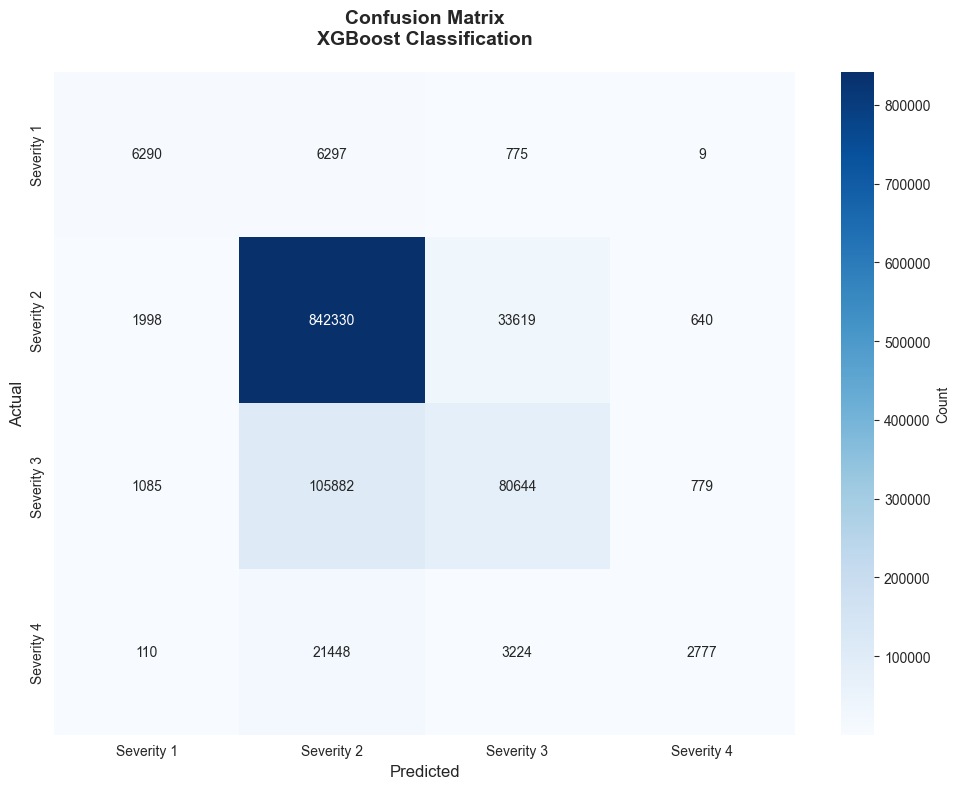

In [10]:
# 5.1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'],
            yticklabels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix\nXGBoost Classification', fontsize=14, weight='bold', pad=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.savefig('figures/classification/01_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# 5.2: Classification Report
report = classification_report(y_test, y_pred,
                               target_names=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'],
                               digits=3)
print(report)

with open('figures/classification/classification_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

              precision    recall  f1-score   support

  Severity 1      0.663     0.470     0.550     13371
  Severity 2      0.863     0.959     0.908    878587
  Severity 3      0.682     0.428     0.526    188390
  Severity 4      0.660     0.101     0.175     27559

    accuracy                          0.841   1107907
   macro avg      0.717     0.489     0.540   1107907
weighted avg      0.825     0.841     0.821   1107907



In [12]:
# Tính Feature Importance (top 20)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})
feature_importance.sort_values('importance', ascending=False, inplace=True)
top_20 = feature_importance.head(20)
print("🔝 Top 5 Feature Importance:")
for i, (feat, imp) in enumerate(top_20.head(5).values, 1):
    print(f"  {i}. {feat}: {imp:.4f}")

🔝 Top 5 Feature Importance:
  1. TRAFFIC_SIGNAL: 0.1679
  2. DISTANCE: 0.1235
  3. STOP: 0.1132
  4. CROSSING: 0.0795
  5. YEAR: 0.0744


## 💡 Bước 6: Kết Luận & Insights

Dựa trên kết quả phân tích XGBoost Classification, ta có thể rút ra những insights sau:

In [13]:
# Tổng kết nhanh
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Training time: {training_time/60:.2f} phút")
print("Top 5 Feature Importance:")
for i, (feat, imp) in enumerate(top_20.head(5).values, 1):
    print(f"  {i}. {feat}: {imp:.4f}")

Test Accuracy: 84.13%
Training time: 1.29 phút
Top 5 Feature Importance:
  1. TRAFFIC_SIGNAL: 0.1679
  2. DISTANCE: 0.1235
  3. STOP: 0.1132
  4. CROSSING: 0.0795
  5. YEAR: 0.0744
